In [1]:
!pip3 install tensorflow

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [3]:
class Predictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2):
        super(Predictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [7]:
def prepare_country_data(country_data, sequence_length=5):
    # Scale the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(country_data.reshape(-1, 1))
    
    # Create sequences
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:(i + sequence_length)])
        y.append(scaled_data[i + sequence_length])
    
    return np.array(X), np.array(y), scaler


In [8]:
def train_model(X, y, epochs=200):
    # Create dataset and dataloader
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(dataset, batch_size=8, shuffle=True)
    
    # Initialize model
    model = Predictor(input_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')
    
    return model

In [9]:
def predict_future(model, last_sequence, scaler, n_future=5):
    model.eval()
    current_sequence = last_sequence.copy()
    predictions = []
    
    with torch.no_grad():
        for _ in range(n_future):
            sequence = torch.FloatTensor(current_sequence).unsqueeze(0)
            pred = model(sequence)
            predictions.append(pred.numpy())
            current_sequence = np.vstack((current_sequence[1:], pred.numpy()))
    
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)
    
    return predictions.flatten()


In [14]:
df = pd.read_csv('../datasets/literacy.csv')
df.head()
df.replace("..", pd.NA, inplace=True)
# Forward fill first, then backward fill to handle any remaining NAs at the start
df.rename(columns={'Entity': 'Country'}, inplace=True)
df = df.ffill().bfill()
df.head()

,Country,Code,Literacy rate 1990,Literacy rate 1991,Literacy rate 1992,Literacy rate 1993,Literacy rate 1994,Literacy rate 1995,Literacy rate 1996,Literacy rate 1997,...,Literacy rate 2014,Literacy rate 2015,Literacy rate 2016,Literacy rate 2017,Literacy rate 2018,Literacy rate 2019,Literacy rate 2020,Literacy rate 2021,Literacy rate 2022,Literacy rate 2023
0,Afghanistan,AFG,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,...,31.0,33.75384,33.75384,33.75384,33.75384,33.75384,33.75384,37.00000,37.00000,37.00000
1,Albania,ALB,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,97.0,97.55390,97.55390,98.81623,98.81623,98.81623,98.81623,98.81623,98.50000,98.50000
2,Algeria,DZA,70.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0,...,75.0,79.60840,79.60840,79.60840,81.40784,81.40784,81.40784,81.40784,81.40784,81.40784
3,Andorra,AND,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.00000,100.00000,100.00000,100.00000,100.00000,100.00000,100.00000,100.00000,100.00000
4,Angola,AGO,67.0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,66.0,66.23586,66.23586,66.23586,66.23586,66.23586,66.23586,66.23586,72.40000,72.40000


In [15]:
cols = [col for col in df.columns if 'Literacy' in col]
    
sequence_length = 5
predictions_by_country = {}
selected_countries = ['United States', 'China', 'Japan', 'Germany', 'United Kingdom']

In [16]:
for country in df['Country']:
        print(f"\nTraining model for {country}")
        
        # Get country data
        country_data = df[df['Country'] == country][cols].values.flatten()

        country_data = country_data.astype(float)
        
        # Prepare data
        X, y, scaler = prepare_country_data(country_data, sequence_length)
        
        if len(X) > 0:  # Check if we have enough data
            # Train model
            model = train_model(X, y)
            
            # Make predictions
            last_sequence = scaler.transform(country_data[-sequence_length:].reshape(-1, 1))
            predictions = predict_future(model, last_sequence, scaler)
            predictions_by_country[country] = predictions
    


Training model for Afghanistan
Epoch [50/200], Loss: 0.0187
Epoch [100/200], Loss: 0.0204
Epoch [150/200], Loss: 0.0163
Epoch [200/200], Loss: 0.0205

Training model for Albania
Epoch [50/200], Loss: 0.0741
Epoch [100/200], Loss: 0.0438
Epoch [150/200], Loss: 0.0401
Epoch [200/200], Loss: 0.0412

Training model for Algeria
Epoch [50/200], Loss: 0.0179
Epoch [100/200], Loss: 0.0143
Epoch [150/200], Loss: 0.0118
Epoch [200/200], Loss: 0.0090

Training model for Andorra
Epoch [50/200], Loss: 0.0000
Epoch [100/200], Loss: 0.0000
Epoch [150/200], Loss: 0.0000
Epoch [200/200], Loss: 0.0000

Training model for Angola
Epoch [50/200], Loss: 0.0481
Epoch [100/200], Loss: 0.0305
Epoch [150/200], Loss: 0.0264
Epoch [200/200], Loss: 0.0366

Training model for Antigua and Barbuda
Epoch [50/200], Loss: 0.0666
Epoch [100/200], Loss: 0.0435
Epoch [150/200], Loss: 0.0388
Epoch [200/200], Loss: 0.0330

Training model for Arab World
Epoch [50/200], Loss: 0.0306
Epoch [100/200], Loss: 0.0236
Epoch [150/20

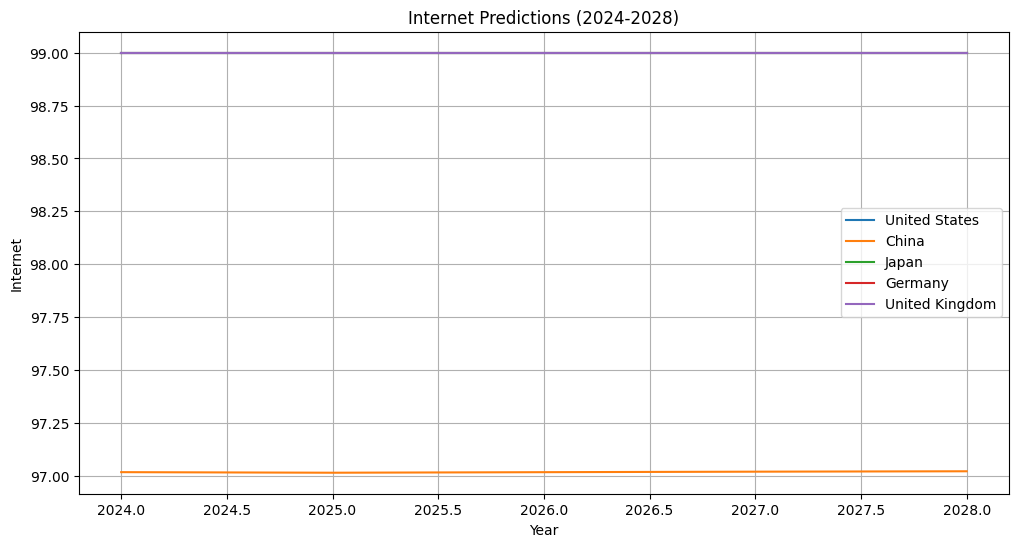


Predicted Internet (2024-2028):

United States:
2024: $99.00
2025: $99.00
2026: $99.00
2027: $99.00
2028: $99.00

China:
2024: $97.02
2025: $97.01
2026: $97.02
2027: $97.02
2028: $97.02

Japan:
2024: $99.00
2025: $99.00
2026: $99.00
2027: $99.00
2028: $99.00

Germany:
2024: $99.00
2025: $99.00
2026: $99.00
2027: $99.00
2028: $99.00

United Kingdom:
2024: $99.00
2025: $99.00
2026: $99.00
2027: $99.00
2028: $99.00


In [17]:
plt.figure(figsize=(12, 6))
for country in selected_countries:
    if country in predictions_by_country:
        plt.plot(range(2024, 2029), predictions_by_country[country], label=country)
plt.title('Internet Predictions (2024-2028)')
plt.xlabel('Year')
plt.ylabel('Internet')
plt.legend()
plt.grid(True)
plt.show()
    
    # Print predictions for selected countries
print("\nPredicted Internet (2024-2028):")
for country in selected_countries:
    if country in predictions_by_country:
        print(f"\n{country}:")
        for year, pred in zip(range(2024, 2029), predictions_by_country[country]):
            print(f"{year}: ${pred:,.2f}")

In [19]:
# Export predictions to CSV
predictions_df = pd.DataFrame()
predictions_df['Country'] = list(predictions_by_country.keys())

for year in range(2024, 2029):
    year_predictions = []
    for country in predictions_df['Country']:
        if country in predictions_by_country:
            year_predictions.append(predictions_by_country[country][year-2024])
        else:
            year_predictions.append(None)
    predictions_df[f'{year} Literacy'] = year_predictions

predictions_df.to_csv('../lstm_datasets/literacy_prediction.csv', index=False)
print("\nPredictions exported to lstm_datasets/literacy_prediction.csv")



Predictions exported to lstm_datasets/literacy_prediction.csv
